## Máster en Big Data y Data Science

### Metodologías de gestión y diseño de proyectos de big data

#### AP2 - Modelado y evaluación

---

En esta libreta se realiza la experimentación para generación del modelo de predicción objetivo del proyecto y la evaluación del mismo.
La versión del dataset a utilizar es la obtenida a partir de las operaciones de transformación.

---

En esta versión de la libreta se va a incorporar el registro de los detalles de la experimentación con la librería MlFlow.

In [17]:
# Se importan las librerías necesarias y se suprimen las advertencias
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=UserWarning)

Se agrega la librería mlflow y se configura inicialmente

In [18]:
import mlflow
import mlflow.sklearn
from datetime import datetime

# Configuración de MLflow
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("Proyecto 13MBID-ABR2526 - Experimentación Original (V2)")

<Experiment: artifact_location=('file:///c:/Users/Administrator/Desktop/Maestria Big Data/13MBID - '
 'Metodologías de gestión y diseño de proyectos Big '
 'Data/13MDBID-ABR2526/notebooks/mlruns/554869276795680037'), creation_time=1762816890631, experiment_id='554869276795680037', last_update_time=1762816890631, lifecycle_stage='active', name='Proyecto 13MBID-ABR2526 - Experimentación Original (V2)', tags={}>

In [19]:
# Lectura de los datos
df = pd.read_csv('../data/processed/bank-processed.csv')
df.head(5)

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,contacted_before
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,261,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,no
1,57,services,married,high.school,no,no,telephone,may,mon,149,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,no
2,37,services,married,high.school,yes,no,telephone,may,mon,226,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,no
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,151,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,no
4,56,services,married,high.school,no,yes,telephone,may,mon,307,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,no


In [20]:
# Se divide el dataset en variables predictoras y variable objetivo
X = df.drop('y', axis=1)
y = df['y']

In [21]:
# Se genera el conjunto de entrenamiento y prueba con estratificación
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [22]:
# Se separan las columnas numéricas
numerical_columns=X_train.select_dtypes(exclude='object').columns
display(numerical_columns)

categorical_columns=X_train.select_dtypes(include='object').columns
display(categorical_columns)

Index(['age', 'duration', 'campaign', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed'],
      dtype='object')

Index(['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month',
       'day_of_week', 'poutcome', 'contacted_before'],
      dtype='object')

In [23]:
# Se verifica la distribución de la variable objetivo en el conjunto de entrenamiento
y_train.value_counts()

y
0    27179
1     3406
Name: count, dtype: int64

In [24]:
# Se crea un pipeline para preprocesamiento de datos
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler  

# Pipeline para valores numéricos
num_pipeline = Pipeline(steps=[
    ('RobustScaler', RobustScaler())
])

# Pipeline para valores categóricos
cat_pipeline = Pipeline(steps=[
    ('OneHotEncoder', OneHotEncoder(drop='first',sparse_output=False))
])

# Se configuran los preprocesadores
preprocessor_full = ColumnTransformer([
    ('num_pipeline', num_pipeline, numerical_columns),
    ('cat_pipeline', cat_pipeline, categorical_columns)
]).set_output(transform='pandas')

In [25]:
preprocessor_train_valid = ColumnTransformer([
    ('num_pipeline', num_pipeline, numerical_columns),
    ('cat_pipeline', cat_pipeline, categorical_columns)
]).set_output(transform='pandas')

In [26]:
# Se ajusta y transforma el conjunto de entrenamiento y prueba
x_train_prep = preprocessor_full.fit_transform(X_train)
x_test_prep = preprocessor_full.transform(X_test)

In [27]:
# Se aplica submuestreo a los datos preprocesados
from sklearn.utils import resample

# Combinar los datos preprocesados con las etiquetas
train_data = x_train_prep.copy()
train_data['target'] = y_train.reset_index(drop=True)

# Separar por clase
class_0 = train_data[train_data['target'] == 0]
class_1 = train_data[train_data['target'] == 1]

# Encontrar la clase minoritaria
min_count = min(len(class_0), len(class_1))
# min_count
# Submuestreo balanceado - tomar una muestra igual al tamaño de la clase minoritaria
class_0_balanced = resample(class_0, n_samples=min_count, random_state=42)
class_1_balanced = resample(class_1, n_samples=min_count, random_state=42)

# Combinar las clases balanceadas
balanced_data = pd.concat([class_0_balanced, class_1_balanced])

# Separar características y objetivo
x_train_resampled = balanced_data.drop('target', axis=1)
y_train_resampled = balanced_data['target']

print(f"Tamaño original: {len(x_train_prep)}")
print(f"Tamaño balanceado: {len(x_train_resampled)}")
print(f"Distribución balanceada: {y_train_resampled.value_counts()}")

Tamaño original: 30585
Tamaño balanceado: 5438
Distribución balanceada: target
0.0    2719
1.0    2719
Name: count, dtype: int64


----

Este apartado se va a cambiar

In [28]:
from sklearn.model_selection import cross_val_score


# Se genera una función para realizar validación cruzada
def cross_val(model):
    scores = cross_val_score(model,x_train_resampled , y_train_resampled, cv=5, scoring='f1')
    print('cross validation f1 scores',scores*100)
    print('cross validation f1 mean',scores.mean()*100)
    print('cross validation f1 std',scores.std())
    print('-'*50)
    scores = cross_val_score(model,x_train_resampled , y_train_resampled, cv=5, scoring='recall')
    print('cross validation recall scores',scores*100)
    print('cross validation recall mean',scores.mean()*100)
    print('cross validation recall std',scores.std())

----

El cambio consiste en que la función directamente registre los detalles de la experimentación en mlflow.

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from mlflow.models import infer_signature

def cross_val_mlflow(model, model_name, params=None):
    """ 
    Realiza validación cruzada y registra los resultados en MLflow.
    """
    with mlflow.start_run(run_name=model_name):
        f1_scores = cross_val_score(model, x_train_resampled , y_train_resampled, cv=5, scoring='f1')
        f1_mean = f1_scores.mean()
        f1_std = f1_scores.std()

        recall_scores = cross_val_score(model, x_train_resampled , y_train_resampled, cv=5, scoring='recall')
        recall_mean = recall_scores.mean()
        recall_std = recall_scores.std()

        precision_scores = cross_val_score(model, x_train_resampled , y_train_resampled, cv=5, scoring='precision')
        precision_mean = precision_scores.mean()
        precision_std = precision_scores.std()

        accuracy_scores = cross_val_score(model, x_train_resampled , y_train_resampled, cv=5, scoring='accuracy')
        accuracy_mean = accuracy_scores.mean()
        accuracy_std = accuracy_scores.std()

        # Entrenamos al modelo
        model.fit(x_train_resampled, y_train_resampled)

        # Hacemos predicciones
        y_pred = model.predict(x_test_prep)

        # Obtenemos model signature
        signature = infer_signature(x_train_resampled, y_pred)

        test_f1 = f1_score(y_test, y_pred)
        test_recall = recall_score(y_test, y_pred)
        test_precision = precision_score(y_test, y_pred)
        test_accuracy = accuracy_score(y_test, y_pred)

        # Registramos los parámetros y métricas en MLflow
        if params:
            mlflow.log_params(params)
        else:
            mlflow.log_params(model.get_params())
        
        mlflow.log_params({
            "train_samples": len(x_train_resampled),
            "test_samples": len(x_test_prep),
            "balancing_method": "undersampling",
            "cv_folds": 5
        })

        # Registramos las métricas de validación cruzada
        mlflow.log_metrics({
            "cv_f1_mean": f1_mean,
            "cv_f1_std": f1_std,
            "cv_recall_mean": recall_mean,
            "cv_recall_std": recall_std,
            "cv_precision_mean": precision_mean,
            "cv_precision_std": precision_std,
            "cv_accuracy_mean": accuracy_mean,
            "cv_accuracy_std": accuracy_std,
        })
        
        mlflow.log_metrics({
            "test_f1": test_f1,
            "test_recall": test_recall,
            "test_precision": test_precision,   
            "test_accuracy": test_accuracy
        })

        # Registramos el modelo
        mlflow.sklearn.log_model(
            model, 
            artifact_path="model", 
            signature=signature
        )

        print(f"Modelo {model_name} registrado en MLflow con ID de ejecución: {mlflow.active_run().info.run_id}")

        return model, {
            "cv_f1_mean": f1_mean,
            "cv_recall_mean": recall_mean,
            "cv_precision_mean": precision_mean,
            "cv_accuracy_mean": accuracy_mean,
            "test_f1": test_f1,
            "test_recall": test_recall,
            "test_precision": test_precision,   
            "test_accuracy": test_accuracy
        }


----
Se cambian estas celdas por una sola que hace todas las llamadas

In [30]:
# Se aplica un modelo de regresión logística
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1,penalty='l2',solver='liblinear',random_state=1,max_iter=100,tol=0.000000001)

# cross validation scores
cross_val(lr)

cross validation f1 scores [52.94117647 51.51793928 54.3876567  52.88197621 50.59578368]
cross validation f1 mean 52.464906470398965
cross validation f1 std 0.01302928668731501
--------------------------------------------------
cross validation recall scores [52.94117647 51.47058824 51.83823529 53.2228361  50.73529412]
cross validation recall mean 52.04162604268227
cross validation recall std 0.009250300788928266


In [31]:
# LinearSVC
from sklearn.svm import LinearSVC
svc = LinearSVC(max_iter=10000,tol=0.001)

# cross validation scores
cross_val(svc)

cross validation f1 scores [53.02752294 51.42332415 54.3876567  52.65082267 50.78196872]
cross validation f1 mean 52.45425903575143
cross validation f1 std 0.012621154408678358
--------------------------------------------------
cross validation recall scores [53.125      51.47058824 51.83823529 53.03867403 50.73529412]
cross validation recall mean 52.041558336041604
cross validation recall std 0.009210601366036826


In [32]:
# knclassifier
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier(n_neighbors=7)

# cross validation scores
cross_val(knc)

cross validation f1 scores [56.77419355 57.35027223 55.25846702 58.84444444 56.37823372]
cross validation f1 mean 56.921122193640464
cross validation f1 std 0.011801759507573232
--------------------------------------------------
cross validation recall scores [56.61764706 58.08823529 56.98529412 60.95764273 58.08823529]
cross validation recall mean 58.14741089806088
cross validation recall std 0.015228328367793535


In [33]:
# decision tree classifier
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier()

# cross validation scores
cross_val(tree)

cross validation f1 scores [70.18469657 68.41186736 69.60203218 70.49608355 69.33797909]
cross validation f1 mean 69.60653175115604
cross validation f1 std 0.007245606577870169
--------------------------------------------------
cross validation recall scores [74.81617647 71.875      74.63235294 74.58563536 72.61029412]
cross validation recall mean 73.70389177770555
cross validation recall std 0.012179893341156852


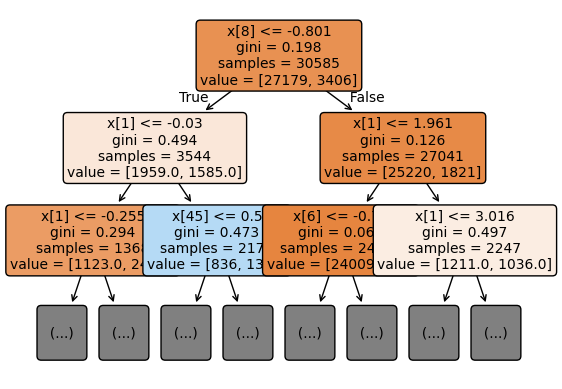

In [34]:
# decision tree plot
from sklearn.tree import plot_tree
tree.fit(x_train_prep, y_train)
plot_tree(tree, filled=True, rounded=True,max_depth=2,fontsize=10)
plt.show()

In [35]:
# Se obtiene la matriz de confusión para el modelo
from sklearn.metrics import confusion_matrix

y_pred = tree.predict(x_test_prep)
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[6355  441]
 [ 401  450]]


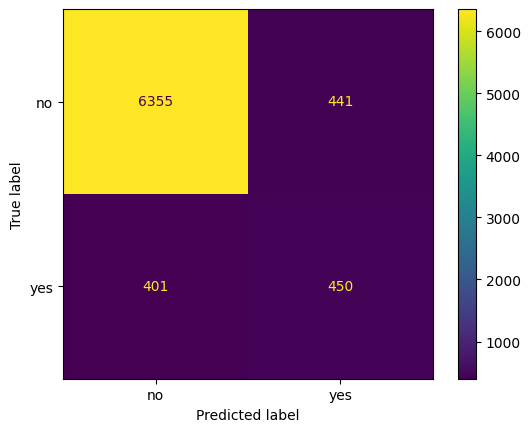

In [36]:
# Se visualiza la matriz de confusión
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no', 'yes'])
disp.plot()

----

Esta es la nueva celda que hace la invocación al proceso con mlflow

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC


# Resultados
resultados = {}

# Método 1 - Regresión
lr = LogisticRegression(C=1,penalty='l2',solver='liblinear',random_state=1,max_iter=100,tol=0.000000001)
model_lr, metrics_lr = cross_val_mlflow(lr, "Logistic Regression")
resultados['Logistic Regression'] = metrics_lr

# Método 2 - SVC
svc = LinearSVC(max_iter=10000,tol=0.001)
model_svc, metrics_svc = cross_val_mlflow(svc, "Linear SVC")
resultados['Linear SVC'] = metrics_svc

# Método 3 - KNN
knc = KNeighborsClassifier(n_neighbors=7)
model_knc, metrics_knc = cross_val_mlflow(knc, "K-Nearest Neighbors")
resultados['K-Nearest Neighbors'] = metrics_knc

# Método 4 - Decision Tree
tree = DecisionTreeClassifier()
model_tree, metrics_tree = cross_val_mlflow(tree, "Decision Tree Classifier")
resultados['Decision Tree Classifier'] = metrics_tree

2025/11/10 19:39:20 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Modelo Logistic Regression registrado en MLflow con ID de ejecución: f0d0283a34a74fe8b2494e7a2ff890e1
Modelo Linear SVC registrado en MLflow con ID de ejecución: cc161c0254ab4c8ab35a9b0df1030caf
Modelo K-Nearest Neighbors registrado en MLflow con ID de ejecución: c04f9f73fb774b1d997a34395a22b2ab
Modelo Decision Tree Classifier registrado en MLflow con ID de ejecución: 79234e9fa91b49aba8f5923fd9863045


A continuación se realiza una comparación de los modelos para seleccionar el que va a ser utilizado posteriormente:

In [43]:
df_comparacion = pd.DataFrame(resultados).T
df_comparacion = df_comparacion.round(4)
df_comparacion = df_comparacion.sort_values(by='test_f1', ascending=False)

display(df_comparacion)

print("\nEl mejor modelo basado en F1 en el conjunto de prueba es:", df_comparacion.index[0])
print(f"Valor de F1 en test: {df_comparacion.iloc[0]['test_f1']}")
print(f"Valor de recall en test: {df_comparacion.iloc[0]['test_recall']}")


,cv_f1_mean,cv_recall_mean,cv_precision_mean,cv_accuracy_mean,test_f1,test_recall,test_precision,test_accuracy
K-Nearest Neighbors,0.5692,0.5815,0.5577,0.5599,0.1867,0.4924,0.1152,0.5226
Decision Tree Classifier,0.6983,0.7407,0.6595,0.6808,0.1712,0.3937,0.1094,0.5758
Linear SVC,0.5245,0.5204,0.5292,0.5279,0.1122,0.2691,0.0709,0.5260
Logistic Regression,0.5246,0.5204,0.5294,0.5281,0.1118,0.2703,0.0705,0.5220



El mejor modelo basado en F1 en el conjunto de prueba es: K-Nearest Neighbors
Valor de F1 en test: 0.1867
Valor de recall en test: 0.4924


#### Predicción con datos nuevos (sin clasificar)

In [44]:
df_nuevos = pd.read_csv('../data/raw/bank-additional-new.csv')
df_nuevos.head(5)

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,contacted_before
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,261,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,NaN
1,57,services,married,high.school,no,no,telephone,may,mon,149,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,NaN
2,37,services,married,high.school,yes,no,telephone,may,mon,226,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,NaN
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,151,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,NaN
4,56,services,married,high.school,no,yes,telephone,may,mon,307,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,NaN


In [45]:
# Diagnosticar el problema con los nuevos datos
print("Información del conjunto de datos nuevos:")
print(f"Forma: {df_nuevos.shape}")
print("\nTipos de datos:")
print(df_nuevos.dtypes)
print("\nValores nulos:")
print(df_nuevos.isnull().sum())
print("\nColumnas categóricas en nuevos datos:")
print(df_nuevos.select_dtypes(include='object').columns.tolist())
print("\nColumnas numéricas en nuevos datos:")
print(df_nuevos.select_dtypes(exclude='object').columns.tolist())

Información del conjunto de datos nuevos:
Forma: (9, 20)

Tipos de datos:
age                   int64
job                  object
marital              object
education            object
housing              object
loan                 object
contact              object
month                object
day_of_week          object
duration              int64
campaign              int64
previous              int64
poutcome             object
emp_var_rate        float64
cons_price_idx      float64
cons_conf_idx       float64
euribor3m           float64
nr_employed         float64
y                    object
contacted_before    float64
dtype: object

Valores nulos:
age                 0
job                 0
marital             0
education           0
housing             0
loan                0
contact             0
month               0
day_of_week         0
duration            0
campaign            0
previous            0
poutcome            0
emp_var_rate        0
cons_price_idx      0
cons_c

In [46]:
# Comparar con los datos de entrenamiento originales
print("Comparación de columnas:")
print(f"Columnas en datos originales: {list(X.columns)}")
print(f"Columnas en datos nuevos: {list(df_nuevos.columns)}")

print("\nColumnas que están en nuevos pero no en originales:")
new_cols = set(df_nuevos.columns) - set(X.columns)
print(new_cols)

print("\nColumnas que están en originales pero no en nuevos:")
missing_cols = set(X.columns) - set(df_nuevos.columns)
print(missing_cols)

Comparación de columnas:
Columnas en datos originales: ['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'contacted_before']
Columnas en datos nuevos: ['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y', 'contacted_before']

Columnas que están en nuevos pero no en originales:
{'y'}

Columnas que están en originales pero no en nuevos:
set()


In [47]:
# Se hace la predicción con los nuevos datos
# Primero, eliminar la columna objetivo si existe y preparar las características
X_new = df_nuevos.drop('y', axis=1) if 'y' in df_nuevos.columns else df_nuevos.copy()

# Asegurar que las columnas estén en el mismo orden que en el entrenamiento
# X_new = X_new[X.columns]

# Manejar la columna contacted_before para que coincida con el formato de entrenamiento
# En entrenamiento: 'no', 'yes' (string)
# En nuevos datos: NaN -> necesita convertirse a 'no' (asumiendo que NaN significa no contactado)
X_new['contacted_before'] = X_new['contacted_before'].fillna('no')

# Convertir cualquier valor numérico a string si es necesario
if X_new['contacted_before'].dtype in ['float64', 'int64']:
    X_new['contacted_before'] = X_new['contacted_before'].map({0.0: 'no', 1.0: 'yes'}).fillna('no')

# Asegurar que contacted_before sea de tipo object como en entrenamiento
X_new['contacted_before'] = X_new['contacted_before'].astype('object')

# Transformar los nuevos datos usando el mismo preprocesador y predecir
try:
    x_new_prep = preprocessor_full.transform(X_new)
    
    y_new_pred = tree.predict(x_new_prep)
    print(f"\nPredicciones: {y_new_pred}")
    
    predictions_df = pd.DataFrame({
        'Cliente': range(1, len(y_new_pred) + 1),
        'Predicción_Numérica': y_new_pred,
        'Suscribirá': ['No' if pred == 0 else 'Sí' for pred in y_new_pred]
    })
    print("\nResultados detallados:")
    print(predictions_df.to_string(index=False))
    
    # Resumen de predicciones
    pred_counts = pd.Series(y_new_pred).value_counts()
    print("\nResumen de predicciones:")
    for pred_val, count in pred_counts.items():
        label = 'No realizará un depósito' if pred_val == 0 else 'Sí realizará un depósito'
        print(f"  {label}: {count} clientes ({count/len(y_new_pred)*100:.1f}%)")
    
except Exception as e:
    print(f"Error durante el preprocesamiento o predicción: {e}")
    print("Información adicional para depuración:")
    print(f"Tipos de datos en X_new:\n{X_new.dtypes}")


Predicciones: [0. 1. 0. 0. 1. 0. 0. 1. 0.]

Resultados detallados:
 Cliente  Predicción_Numérica Suscribirá
       1                  0.0         No
       2                  1.0         Sí
       3                  0.0         No
       4                  0.0         No
       5                  1.0         Sí
       6                  0.0         No
       7                  0.0         No
       8                  1.0         Sí
       9                  0.0         No

Resumen de predicciones:
  No realizará un depósito: 6 clientes (66.7%)
  Sí realizará un depósito: 3 clientes (33.3%)
